# Examen

## Importation des modules pythons

In [2]:
# traitement de données
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Comparaison metriques 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.datasets import make_classification
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

# Classifiers

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
import time

# Pipeline et sortie
from sklearn.pipeline import Pipeline
import pickle

## Importation des données

In [22]:
# Importation Data entrainement
DataFrame = pd.read_csv('./Train.csv', sep=';' , decimal = ",",header=0)#read csv file
print(DataFrame.head())
print(DataFrame.shape)


   ID   LB  AC  FM  UC  ASTV  MSTV  ALTV  MLTV  DL  ...  Min  Max  Nmax  \
0   1  120   0   0   0    73   0.5    43   2.4   0  ...   62  126     2   
1   2  132   4   0   4    17   2.1     0  10.4   2  ...   68  198     6   
2   3  133   2   0   5    16   2.1     0  13.4   2  ...   68  198     5   
3   4  134   2   0   6    16   2.4     0  23.0   2  ...   53  170    11   
4   5  132   4   0   5    16   2.4     0  19.9   0  ...   53  170     9   

   Nzeros  Mode  Mean  Median  Variance  Tendency  Classe  
0       0   120   137     121        73         1       2  
1       1   141   136     140        12         0       1  
2       1   141   135     138        13         0       1  
3       0   137   134     137        13         1       1  
4       0   137   136     138        11         1       1  

[5 rows x 24 columns]
(1638, 24)


In [23]:
# Transformation en numpy array 
X = DataFrame.iloc[:,0:23].values # variables/métriques
X = X.astype(float)
labels = DataFrame.iloc[:, 23].values # labels à trouver

Nous avons séparé la colonne Classe qui est le résultat attendu des autres colonnes qui sont des métriques.

## Mise en place de la comparaison des classifieurs

In [24]:
# Dictionnaire des classifieurs à comparer 

clfs = {
'RF': RandomForestClassifier(n_estimators=50, random_state=1),
'KNN': KNeighborsClassifier(n_neighbors=10),
'BAG' : BaggingClassifier(n_estimators = 50, random_state =1),
'ADA': AdaBoostClassifier(n_estimators = 50, random_state =1),
'MLP': MLPClassifier(hidden_layer_sizes= (50,20), alpha = 0.001, max_iter = 100, random_state =1),
'NB': GaussianNB(),
'CART': DecisionTreeClassifier(criterion='gini', random_state =1),
'ID3': DecisionTreeClassifier(criterion='entropy', random_state =1)
}


In [38]:
# Fonction de comparaison

## Comparaison KFold

def run_classifiers(X, labels, modeles):
    """
    Run l'ensemble des classifiers contenus dans modeles, les compare et les trie suivant leur accuracy
    arguments: 
        X(np array): jeu de données contenant uniquement les métriques
        labels(np array): status du jeu de données
        modeles(dic): ensemble des classifieurs à comparer
    retourne: liste_classee liste de tuple (classifieur, accuracy) classé par accuracy
        
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    liste_classee = []
    for mod in modeles:
        begin = time.time()
        modele = modeles[mod]
        cv_acc = cross_val_score(modele, X, labels, cv = kf)
        end = time.time()
        #cv_precision = cross_val_score(modele, X, labels, cv = kf, scoring = 'precision')
        #cv_auc = cross_val_score(modele, X, labels, cv = kf, scoring = 'roc_auc')
        print("Accuracy for {} is : {} +/- {} (in {} seconds)".format(mod,np.mean(cv_acc), np.std(cv_acc), end - begin))
        liste_classee.append((mod ,np.mean(cv_acc)))
    liste_classee.sort(key=lambda tup: tup[1], reverse= True)
    return liste_classee

## Comparaison toutes transformations de données

def run_classifiers_all_forms(X, labels, modeles):
    """
    Traite les données et les fait tourner sur l'ensemble des classifieurs. 
    arguments: 
        X(np array): jeu de données contenant uniquement les métriques
        labels(np array): status du jeu de données
        modeles(dic): ensemble des classifieurs à comparer
    print: les meilleurs tuples (modele,accuracy) de change traitement de données
        
    """
    # non traité
    print("Non traité")
    print()
    base_list = run_classifiers(X, labels, clfs)
    
    # MM Scaler 
    print("MinMax Scaler")
    print()
    MM_scaler = MinMaxScaler()
    MM_scaler.fit(X)
    X_norm_MM = MM_scaler.transform(X)
    MM_list = run_classifiers(X_norm_MM, labels, modeles)
    

    # Standard Scaler
    print("Standard Scaler")
    print()
    Standard_scaler = StandardScaler()
    Standard_scaler.fit(X)
    X_norm_Stand = Standard_scaler.transform(X)
    SS_list = run_classifiers(X_norm_Stand, labels, modeles)

    # L'étape de PCA ne sera pas faite à cause du manque de temps
    # PCA 
    print("PCA ")
    print()
    nb_variable = X.shape[1]
    pca = PCA(n_components = nb_variable)
    pca.fit(X_norm_Stand)
    X_pca = pca.transform(X_norm_Stand)
    PCA_list = run_classifiers(X_pca, labels, modeles)
    
    # Choisir le meilleurs
    print("meilleure accu base {} pour modele {}".format(base_list[0][1], base_list[0][0]))
    print("meilleure accu MM_norm {} pour modele {}".format(MM_list[0][1], MM_list[0][0]))
    print("meilleure accu SS_norm {} pour modele {}".format(SS_list[0][1], SS_list[0][0]))
    print("meilleure accu PCA {} pour modele {}".format(PCA_list[0][1], PCA_list[0][0]))





In [39]:
run_classifiers_all_forms(X, labels, clfs)

Non traité

Accuracy for RF is : 0.9548295666442904 +/- 0.011458379645800194 (in 0.8596358299255371 seconds)
Accuracy for KNN is : 0.8968300141717014 +/- 0.013257331549054669 (in 0.13952898979187012 seconds)
Accuracy for BAG is : 0.9615424778100993 +/- 0.015503570648532323 (in 2.421970844268799 seconds)
Accuracy for ADA is : 0.9523980010442307 +/- 0.016962753554486117 (in 0.902245283126831 seconds)
Accuracy for MLP is : 0.8803684642351011 +/- 0.02355404158960254 (in 2.841613531112671 seconds)
Accuracy for NB is : 0.8974565525471769 +/- 0.02221583283347104 (in 0.017745018005371094 seconds)
Accuracy for CART is : 0.9481166554784813 +/- 0.008359053297754705 (in 0.08324050903320312 seconds)
Accuracy for ID3 is : 0.9426232565077944 +/- 0.010406561093729203 (in 0.06145453453063965 seconds)
MinMax Scaler

Accuracy for RF is : 0.9542198105467292 +/- 0.011552755279240816 (in 0.9138751029968262 seconds)
Accuracy for KNN is : 0.9175915566495115 +/- 0.011349088194836538 (in 0.22846603393554688 sec

## Résultats

Du fait que l'examen porte sur l'accuracy, J'ai décidé de n'étudiais que ce critère de qualité. Aussi nous obtenons ce tableau :

| Méthode/métriques  | Non traitré | MinMax Scaler | Standard Scaler   |    PCA     |
| :------------------|:-----------:|:-------------:|:-----------------:|:----------:|
| RF   |   0.9548295666442904   |  0.9542198105467292   |  0.9548295666442904    |  0.9279611397031402   |
| KNN  |   0.8968300141717014   |  0.9175915566495115   |  0.9059950026105767    |  0.9059950026105767   |
| BAG  |   **0.9615424778100993**   |  0.9609327217125383   |  **0.9615424778100993**    |  0.9243026031177743   |
| ADA  |   0.9523980010442307   |  0.9523980010442307   |  0.9530077571417916    |  0.9145371820690684   |
| MLP  |   0.8803684642351011   |  0.9322443499664355   |  0.9462855224882525    |  0.9426213918102484   |
| NB   |   0.8974565525471769   |  0.8901394793764451   |  0.8901394793764451    |  0.7978984858655925   |
| CART |   0.9481166554784813   |  0.9475050346833743   |  0.9456739016931455    |  0.9017248452301037   |
| ID3  |   0.9426232565077944   |  0.9426232565077944   |  0.9426213918102484    |   0.8968374729618857  |

Comme nous l'observons la meilleure méthode est le BaggingClassifier avec une accuracy moyenne de 96.15%, il est aussi bon pour les données de base ue pour celles normalisées par Standard Scaler. Par simplicité et car Standard Scaler n'apporte pas plus, du fait que c'est un arbre de décision, nous utiliserons les données non normées.

 ## Optimisation 

In [27]:
# Creation jeu de données test

X_train, X_test, labels_train, labels_test = train_test_split(X, labels, train_size = 0.5, random_state =1)

In [33]:
# Meilleur classifieur

best_classifieur = clfs["BAG"] # meilleurs classifieur

In [32]:
# Observation de l'importance des différentes métriques
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, labels_train)
importances=clf.feature_importances_

std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
sorted_idx = np.argsort(importances)[::-1]
features=DataFrame.columns[:23]
print(features[sorted_idx])

padding = np.arange(X_train.size/len(X_train)) + 0.5
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

Index(['ASTV', 'MSTV', 'ID', 'ALTV', 'AC', 'Mean', 'Variance', 'Width', 'Min',
       'Median', 'Mode', 'LB', 'MLTV', 'DP', 'Max', 'UC', 'Nmax', 'FM',
       'Tendency', 'DL', 'Nzeros', 'DS', 'DR'],
      dtype='object')


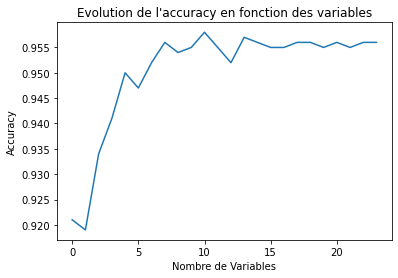

In [34]:
# Recherche du seuil de métrique avant sur-apprentissage
scores=np.zeros(X_train.shape[1]+1)
for f in np.arange(0, X_train.shape[1]+1):
    X1_f = X_train[:,sorted_idx[:f+1]]
    X2_f = X_test[:,sorted_idx[:f+1]]
    best_classifieur.fit(X1_f,labels_train)
    Ybest_classifieur=best_classifieur.predict(X2_f)
    scores[f]=np.round(accuracy_score(labels_test,Ybest_classifieur),3)
plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Accuracy")
plt.title("Evolution de l'accuracy en fonction des variables")
plt.show()

### Reduction de l'espace d'apprentissage

Un risque avec l'apprentissage automatique c'est que nous sur-entrainons notre méthode. En effet, en lui donnant des métriques de faible qualité d'apprentissage nous risquons d'augmenter le bruit et donc de diminuer la qualité de notre méthode. C'est pourquoi il est important d'étudier les métriques utilisées pour ne garder que celles apportant de l'information.

#### Résultats 

Comme nous l'obervons dans le plot ci dessus il y a une chute puis stagnation de l'information à partir de la 10eme  variables/métrique ce qui indique que celles après ont un risque d'apporté du bruit. Aussi nous garderons 10 variables pour la suite.

In [49]:
# Optimisation des paramètres du classifieur

## liste des paramètres 
listparam = [50,100,200,300,400]
bootstrap_p = [True, False]
oob_score_p = [False, 1, 2, 5]

## Test des paramètres
param_grid=dict(n_estimators=listparam, bootstrap = bootstrap_p, oob_score = oob_score_p)
grid = GridSearchCV(BaggingClassifier(), param_grid,cv=5, scoring='accuracy')
grid.fit(X[: ,sorted_idx[:10]],labels)



print(grid.best_params_)
print(grid.best_score_)


{'bootstrap': True, 'n_estimators': 400, 'oob_score': 2}
0.7733366897889163


### Recherche des meilleurs paramètres

Une fois l'espace des métriques réduit il faut chercher à optimiser notre classifieur à ce qu'il soit le plus juste possible pour notre jeu de donnée. 

#### Résultats

Nous observons que les meilleurs paramètres, dans ceux étudiés, sont :
- bootstrap = True 
- n_estimator  = 400
- oob_score = 2
Ils seront utilisés dans la dernière étape de prédiction du jeu de données final.

## Prediction du jeu noté 

In [61]:
#Lire Data à prédire
DataFramePredire = pd.read_csv('./Test.csv', sep=';', decimal= "," , header=0)#read csv file
X_pred = DataFramePredire.iloc[:,:].values
print(DataFramePredire.head)

(488, 23)


In [62]:
# classifieur final et prédiction

final_classifieur = BaggingClassifier(bootstrap =  True, n_estimators=  400, oob_score = 2)
final_classifieur.fit(X[: ,sorted_idx[:10]], labels)
prediction = final_classifieur.predict(X_pred[: ,sorted_idx[:10]])

print(prediction.shape)

(488,)


In [82]:
# Export en Csv
prediction = prediction.astype(int)

import csv
with open('prediction_bouirdene_sophiane.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=';',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['Id', 'Prediction'])
    for i in range (len(prediction)): 
        spamwriter.writerow([X_pred[i,0].astype(int), prediction[i]])